# EAS 4610
## Final Group Project
## Glacial Cycles (Pollard 1982)

### Dennis Frank
### Marcus Morris
### Nathan Warner

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
import pandas as pd

# Introduction

# Equations

In [187]:
#Constants

##Equation 1
A = 5.77e-4 # 1/(m^3 yr)
alpha = 5
beta = 2

##Equation 2
a=0.81e-3 #Snowfall Constant, Unit:(1/yr) 
b=0.3e-6 #Ice Melt Constant, Unit:(1/(m*yr))
k_sens=25 #Insolation Sensitivity (m*day/Ly)
k_sens = k_sens / 41840 # 1 Ly = 41840 J/m^2
S=0 #Elevation of Current Sea Level
pi=917 #ice density (kg/m^3)
pw=1027 #sea water density (kg/m^3)

##Equation 3
r = 0.3
nu = 100 # km^2/yr
nu = nu * 1000 * 1000


In [205]:
#Function for Calculating the Mass Balance, G: (Snowfall - Ice Melt)
def G(h,h_prime,h_prev,h_prime_prev,E0,dQ, t_param): #h:ice height, h':bedrock elevation, x:distance, E0:current equilibrium altitude, dq:insolation change @ 65°N
    E = E0 + k_sens*dQ
    H = h+h_prime #Surface Elevation: H=h+h'
#    if (pi*h_prev < (pw*(S-h_prime_prev))) and (h_prime < S): #Calving Conditional Statement (maybe put this in separte fxn)
#        return -20
#     if (H-E) <= -1000:
#         return a*(H-E) - b*((H-E)**2)
#     else:
    return 0.56

#0.56 * np.sin((3*2*np.pi)/(nt) * t_param) ##oscilating G parameter

# Numerical Methods

In [206]:
#Model Parameters
t_f = 1500
x_f = 4884000
dt = 0.01 #yr
dx = 55500 #m
nt = int(t_f/dt) + 1
nx = int(x_f/dx) + 1
x = np.linspace(0, x_f, nx)
t = np.linspace(0, t_f, nt)

c_nu = (nu * dt) / (dx**2)
c_A = (A * dt) / (4*dx**2)

### Model with IC: h = 0 m

In [207]:
h1 = np.zeros([nx, nt])
h_prime = np.zeros([nx, nt])

## Initial conditions
h_0 = np.zeros([nx])
h_prime_0 = np.zeros([nx])
h_naught = np.zeros([nx])

h1[:, 0] = h_0
h_prime[:, 0] = h_prime_0

## EQUATION 3 MATRICES
h_prime_data = np.array([c_nu*np.ones(nx), (1-2*c_nu)*np.ones(nx), c_nu*np.ones(nx)])
h_prime_diags = np.array([-1, 0, 1])
h_prime_M_3 = spdiags(h_prime_data, h_prime_diags, nx, nx).toarray()

h_0_data = np.array([-c_nu*np.ones(nx), (2*c_nu)*np.ones(nx), -c_nu*np.ones(nx)])
h_0_diags = np.array([-1, 0, 1])
h_0_M_3 = spdiags(h_0_data, h_0_diags, nx, nx).toarray()

h_data = np.array([r*c_nu*np.ones(nx), (-2*r*c_nu)*np.ones(nx), r*c_nu*np.ones(nx)])
h_diags = np.array([-1, 0, 1])
h_M_3 = spdiags(h_data, h_diags, nx, nx).toarray()

## EQUATION 3 BOUNDARY CONDITIONS
h_prime_M_3[0, 0] = 0
h_prime_M_3[0, 1] = 0
h_prime_M_3[-1, -1] = 0
h_prime_M_3[-1, -2] = 0

h_0_M_3[0, 0] = 1
h_0_M_3[0, 1] = 0
h_0_M_3[-1, -1] = 1
h_0_M_3[-1, -2] = 0

h_M_3[0, 0] = 0
h_M_3[0, 1] = 0
h_M_3[-1, -1] = 0
h_M_3[-1, -2] = 0

#Define Insolation as a Function of Time (Q)
df = pd.read_csv('Milankovitch.dat',skiprows=1300,delim_whitespace=True, names=['year','lat','Q','x','y','z','v']) #only first 3 rows are of interest
Q = df['Q'].to_numpy() #values in W/m^2
n = np.ceil(len(t)/len(Q))
Q = list(np.repeat(Q,n)) #repeat values
#Run Loop to calculate dQ
Q_present=Q[-1]
dQ = np.ones((len(Q),1))
for i in np.arange(len(Q)):
    dQ[i] = Q[i] - Q_present
dQ = dQ.reshape(-1)
dQ = dQ * 60 * 60 * 24 # convert to J/(m^2 * day)
#Define Equilibrium-Line Altitude as a Function of latitude
E0 = (0.9e-3)*x - 99.9

## MASTER LOOP
for k in np.arange(0, nt - 1):
    # EQUATION 1 MATRICES
    K = np.zeros([nx])
    K[1:-1] = h1[1:-1,k]**alpha + abs(((h1[2:nx,k] - h1[0:nx-2,k])/(2*dx)) + ((h_prime[2:nx,k] - h_prime[0:nx-2,k])/(2*dx)))**beta

    h_1 = np.zeros(nx)
    h_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
    h_2 = np.zeros(nx)
    h_2[1:nx-1] = 1 - 8*c_A*K[1:nx-1]
    h_2[0] = 1
    h_2[-1] = 1
    h_3 = np.zeros(nx)
    h_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
    h_diags = np.array([-1, 0, 1])
    h_M = spdiags(np.array([h_1, h_2, h_3]), h_diags, nx, nx).toarray()

    h_p_1 = np.zeros(nx)
    h_p_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
    h_p_2 = np.zeros(nx)
    h_p_2[1:nx-1] = -8*c_A*K[1:nx-1]
    h_p_3 = np.zeros(nx)
    h_p_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
    h_p_diags = np.array([-1, 0, 1])
    h_p_M = spdiags(np.array([h_p_1, h_p_2, h_p_3]), h_diags, nx, nx).toarray()
    
    # Find G
    G_M = np.zeros(nx)
    this_dQ = dQ[k]
    G_M[0] = 0
    
    for i in np.arange(1, nx-1):
        G_M[i] = G(h1[i, k], h_prime[i, k], h1[i-1, k], h_prime[i-1, k], E0[i], this_dQ, k)
        
    # Find h at next time step
    h_new = h_M@h1[:,k] + h_p_M@h_prime[:,k] + G_M*dt
    h1[:, k+1] = h_new.transpose()
    
    # Find h_prime at next time step    
    h_prime_new = h_prime_M_3@h_prime[:,k] + h_0_M_3@h_naught[:] + h_M_3@h1[:,k]
    h_prime[:, k+1] = h_prime_new.transpose()

### Model with IC: h = 500 m

In [192]:
h2 = np.zeros([nx, nt])
h_prime = np.zeros([nx, nt])

## Initial conditions
h_0 = np.zeros([nx])
h_0 = 500
h_prime_0 = np.zeros([nx])
h_naught = np.zeros([nx])

h2[:, 0] = h_0
h_prime[:, 0] = h_prime_0

## EQUATION 3 MATRICES
h_prime_data = np.array([c_nu*np.ones(nx), (1-2*c_nu)*np.ones(nx), c_nu*np.ones(nx)])
h_prime_diags = np.array([-1, 0, 1])
h_prime_M_3 = spdiags(h_prime_data, h_prime_diags, nx, nx).toarray()

h_0_data = np.array([-c_nu*np.ones(nx), (2*c_nu)*np.ones(nx), -c_nu*np.ones(nx)])
h_0_diags = np.array([-1, 0, 1])
h_0_M_3 = spdiags(h_0_data, h_0_diags, nx, nx).toarray()

h_data = np.array([r*c_nu*np.ones(nx), (-2*r*c_nu)*np.ones(nx), r*c_nu*np.ones(nx)])
h_diags = np.array([-1, 0, 1])
h_M_3 = spdiags(h_data, h_diags, nx, nx).toarray()

## EQUATION 3 BOUNDARY CONDITIONS
h_prime_M_3[0, 0] = 0
h_prime_M_3[0, 1] = 0
h_prime_M_3[-1, -1] = 0
h_prime_M_3[-1, -2] = 0

h_0_M_3[0, 0] = 1
h_0_M_3[0, 1] = 0
h_0_M_3[-1, -1] = 1
h_0_M_3[-1, -2] = 0

h_M_3[0, 0] = 0
h_M_3[0, 1] = 0
h_M_3[-1, -1] = 0
h_M_3[-1, -2] = 0

#Define Insolation as a Function of Time (Q)
df = pd.read_csv('Milankovitch.dat',skiprows=1300,delim_whitespace=True, names=['year','lat','Q','x','y','z','v']) #only first 3 rows are of interest
Q = df['Q'].to_numpy() #values in W/m^2
n = np.ceil(len(t)/len(Q))
Q = list(np.repeat(Q,n)) #repeat values
#Run Loop to calculate dQ
Q_present=Q[-1]
dQ = np.ones((len(Q),1))
for i in np.arange(len(Q)):
    dQ[i] = Q[i] - Q_present
dQ = dQ.reshape(-1)
dQ = dQ * 60 * 60 * 24 # convert to J/(m^2 * day)
#Define Equilibrium-Line Altitude as a Function of latitude
E0 = (0.9e-3)*x - 99.9

## MASTER LOOP
for k in np.arange(0, nt - 1):
    # EQUATION 1 MATRICES
    K = np.zeros([nx])
    K[1:-1] = h2[1:-1,k]**alpha + abs(((h2[2:nx,k] - h2[0:nx-2,k])/(2*dx)) + ((h_prime[2:nx,k] - h_prime[0:nx-2,k])/(2*dx)))**beta

    h_1 = np.zeros(nx)
    h_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
    h_2 = np.zeros(nx)
    h_2[1:nx-1] = 1 - 8*c_A*K[1:nx-1]
    h_2[0] = 1
    h_2[-1] = 1
    h_3 = np.zeros(nx)
    h_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
    h_diags = np.array([-1, 0, 1])
    h_M = spdiags(np.array([h_1, h_2, h_3]), h_diags, nx, nx).toarray()

    h_p_1 = np.zeros(nx)
    h_p_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
    h_p_2 = np.zeros(nx)
    h_p_2[1:nx-1] = -8*c_A*K[1:nx-1]
    h_p_3 = np.zeros(nx)
    h_p_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
    h_p_diags = np.array([-1, 0, 1])
    h_p_M = spdiags(np.array([h_p_1, h_p_2, h_p_3]), h_diags, nx, nx).toarray()
    
    # Find G
    G_M = np.zeros(nx)
    this_dQ = dQ[k]
    G_M[0] = 0
    
    for i in np.arange(1, nx-1):
        G_M[i] = G(h2[i, k], h_prime[i, k], h2[i-1, k], h_prime[i-1, k], E0[i], this_dQ, k)
        
    # Find h at next time step
    h_new = h_M@h2[:,k] + h_p_M@h_prime[:,k] + G_M*dt
    h2[:, k+1] = h_new.transpose()
    
    # Find h_prime at next time step    
    h_prime_new = h_prime_M_3@h_prime[:,k] + h_0_M_3@h_naught[:] + h_M_3@h2[:,k]
    h_prime[:, k+1] = h_prime_new.transpose()

KeyboardInterrupt: 

# Results

### Model with IC: h = 0 m

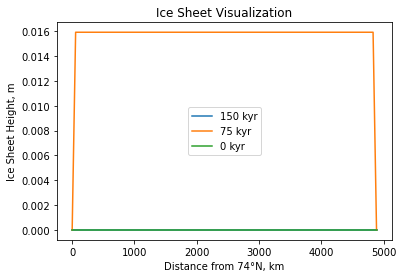

In [217]:
#Ice Sheet Visualization
x_km = x/1000
plt.plot(x_km, h1[:,150000],label= "150 kyr")
plt.plot(x_km, h1[:,int(150000/2)],label= "75 kyr")
plt.plot(x_km, h1[:,0],label= "0 kyr")

plt.legend()
plt.title("Ice Sheet Visualization")
plt.xlabel("Distance South from 74°N, km")
plt.ylabel("Ice Sheet Height, m")
plt.show()

In [208]:
#Apply Trapezoid Rule for Numerical Integration of Ice Sheet Cross-Sectional Area
hsum1=np.zeros(nt)
for i in np.arange(0, nt):
    for j in np.arange(0, nx-1):
        hsum1[i] += (h1[j,i] + h1[j+1,i]) * (dx/2)

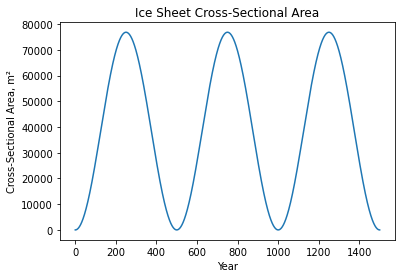

In [213]:
#Visualized Cross-Sectional Area
plt.plot(t,hsum1)
plt.title("Ice Sheet Cross-Sectional Area")
plt.xlabel("Year")
plt.ylabel("Cross-Sectional Area, m²")
plt.show()

### Model with IC: h = 500 m

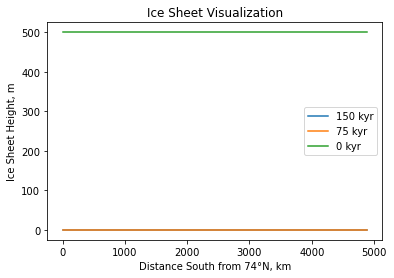

In [218]:
#Ice Sheet Visualization
x_km = x / 1000
plt.plot(x_km, h2[:,150000],label= "150 kyr")
plt.plot(x_km, h2[:,int(150000/2)],label= "75 kyr")
plt.plot(x_km, h2[:,0],label= "0 kyr")

plt.title("Ice Sheet Visualization")
plt.xlabel("Distance South from 74°N, km")
plt.ylabel("Ice Sheet Height, m")
plt.legend()
plt.show()

In [186]:
#Apply Trapezoid Rule for Numerical Integration of Ice Sheet Cross-Sectional Area
hsum2=np.zeros(nt)
for i in np.arange(0, nt):
    for j in np.arange(0, nx-1):
        hsum2[i] += (h2[j,i] + h2[j+1,i]) * (dx/2)

In [212]:
#Visualized Cross-Sectional Area
plt.plot(t,hsum2)
plt.title("Ice Sheet Cross-Sectional Area")
plt.xlabel("Year")
plt.ylabel("Cross-Sectional Area, m²")
plt.show()

NameError: name 'hsum2' is not defined

# Video Walkthrough

# References